# Modelling Afterpay's customer growth
> How can we model the growth in Afterpay's customer base?

- toc: true 
- badges: true
- comments: true
- categories: [Bayesian,PyMC3,Finance,Monte Carlo Simulation,Afterpay]
    
- image: images/2020-08-13-Modelling-Afterpays-Customer-Growth/header.png

## The Context


> Important:  Obviously I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.


## The Model

First off, let's load in a bunch of libraries.

In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

from io import StringIO
import pandas as pd

import math

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')


While reading through Afterpay's releases to the markets, I came across this chart, which appears on page 3 of [this](https://www.afterpaytouch.com/images/APT_ASX-Announcement_Q2-FY18_16-Jan-Final-2.pdf) release.


![Image of Afterpay custmer growth](../images/2020-08-13-Modelling-Afterpays-Customer-Growth/CustomerGrowth.png)


csv_data = StringIO('''afterpay_rev,date,month_count
            0.0,30-sep-2015,0 
            0.2,31-dec-2015,3 
            0.3,31-mar-2016,6 
            0.8,30-jun-2016,9 
            1.7,30-sep-2016,12
            4.3,31-dec-2016,15
            6.0,31-mar-2017,18
            10.9,30-jun-2017,21
            14.2,30-sep-2017,24
            22.2,31-dec-2017,27
            ''')

#Underlying sales

csv_data = StringIO('''anz_underlying_sales_value,date,month_count
0,FY15,0
37.3,FY16,12
561.2,FY17,24
2184.6,FY18,36
4314.1,FY19,48
6566.9,FY20,60''')

df = pd.read_csv(csv_data, sep=",")
plt.plot(df.month_count,df.anz_underlying_sales_value,color='r')
plt.ylabel('Millions of customers')
plt.xlabel('Months after launch')
plt.grid()
plt.show()

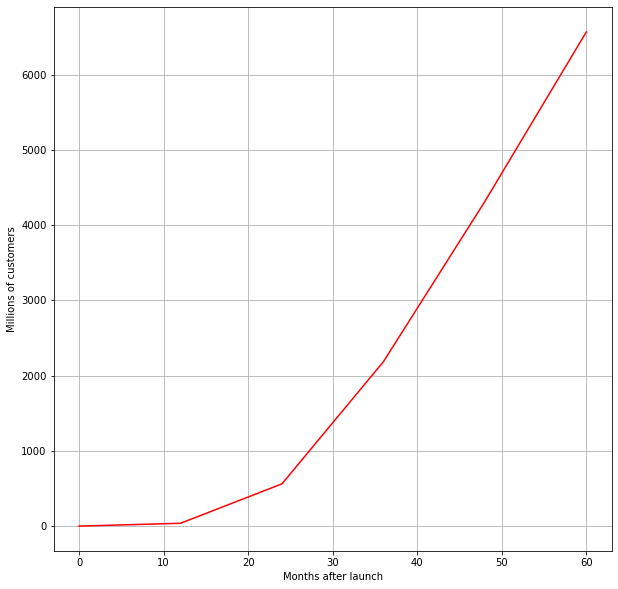

In [2]:
#Underlying sales
csv_data = StringIO('''anz_underlying_sales_value,date,month_count
0,FY15,0
37.3,FY16,12
561.2,FY17,24
2184.6,FY18,36
4314.1,FY19,48
6566.9,FY20,60''')

df = pd.read_csv(csv_data, sep=",")
plt.plot(df.month_count,df.anz_underlying_sales_value,color='r')
plt.ylabel('Millions of customers')
plt.xlabel('Months after launch')
plt.grid()
plt.show()

from scipy.optimize import curve_fit

def sigmoid(x, a, b, l):
     y = l / (1 + np.exp(-b*(x-a)))
     return y

xdata = df.month_count.values
ydata = df.anz_underlying_sales_value.values

popt, pcov = curve_fit(sigmoid, xdata, ydata)

x = np.linspace(0,60, 61)

y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x,y, label='fit')

#section = np.linspace(20,40, 100)
#plt.fill_between(section,sigmoid(section, *popt))

plt.title('ANZ Sales by preceding Financial Year')
plt.xlabel('Months after launch')
plt.ylabel('ANZ Sales ($M AUD)')
plt.legend(loc='best')
plt.show()

[  2.17012649 -17.61639881 -58.725     ]


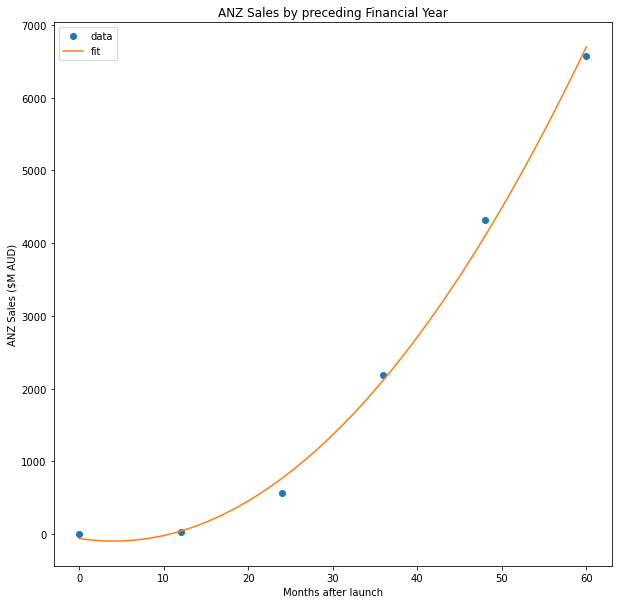

In [23]:
from scipy.optimize import curve_fit

def quadratic(x, a, b, c):
     y = a * x**2 + b * x + c
     return y

xdata = df.month_count.values
ydata = df.anz_underlying_sales_value.values

popt, pcov = curve_fit(quadratic, xdata, ydata)

print(popt)
x = np.linspace(0,60, 61)
y = quadratic(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x,y, label='fit')

#section = np.linspace(20,40, 100)
#plt.fill_between(section,sigmoid(section, *popt))

plt.title('ANZ Sales by preceding Financial Year')
plt.xlabel('Months after launch')
plt.ylabel('ANZ Sales ($M AUD)')
plt.legend(loc='best')
plt.show()

Ok, let's pause for a moment, and actually think about what this curve represents.

It's the sum, or integral of the total sales for the preceding 1 year period. 

Now, let's find the derivative of this function, which will give us the instantanious rate of sales, at any given point in time.

[4.59234416e+01 1.09078695e-01 7.94167267e+03]


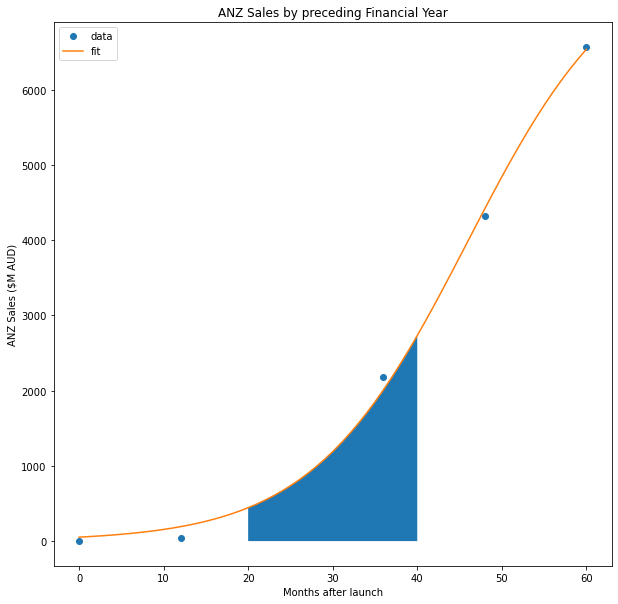

In [4]:
xdata = df.month_count.values
ydata = df.anz_underlying_sales_value.values

popt, pcov = curve_fit(quadratic, xdata, ydata)
print(popt)


x = np.linspace(0,60, 61)

y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x,y, label='fit')


section = np.linspace(20,40, 100)

plt.fill_between(section,sigmoid(section, *popt))
plt.title('ANZ Sales by preceding Financial Year')
plt.xlabel('Months after launch')
plt.ylabel('ANZ Sales ($M AUD)')
plt.legend(loc='best')
plt.show()


In [24]:
from sympy import *
a,b,c, x,y = symbols('a b c x y')
init_printing(use_unicode=True)
#expr = diff(l / (1 + exp(-b*(x-a))),x)

expr = diff(a*x**2 + b*x + c ,x)
print(expr)

f = lambdify([a,b,x], expr, "numpy")
#print(expr)


2*a*x + b


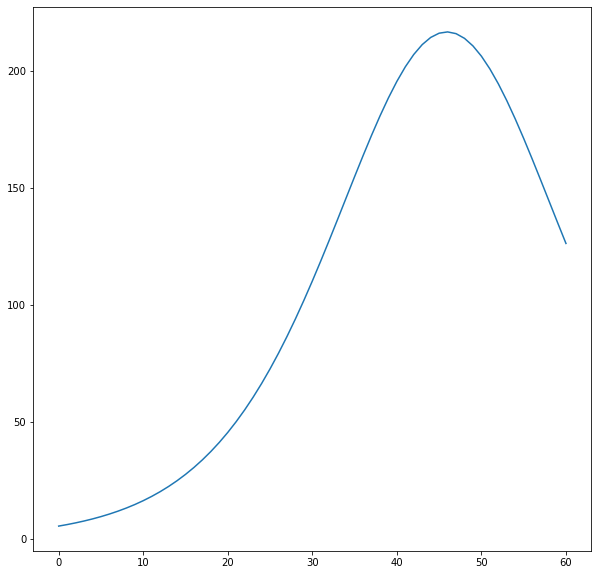

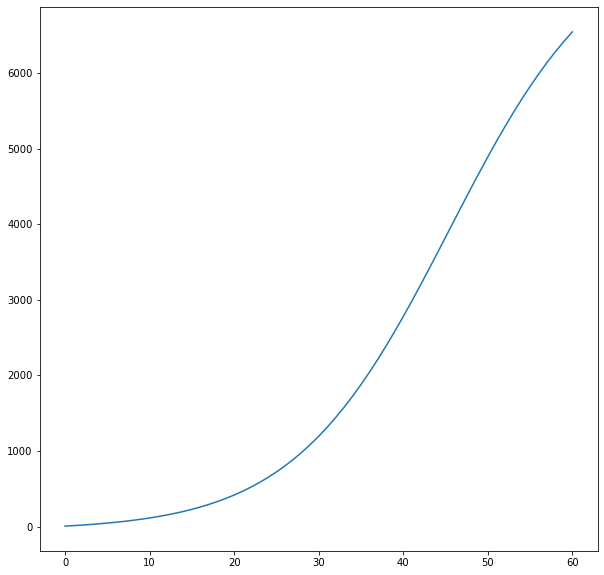

In [6]:
x = np.linspace(0,60, 61)
y = f(4.59234416e+01,1.09078695e-01,7.94167267e+03,x)
plt.plot(x,y)
plt.show()

plt.plot(np.cumsum(y))
plt.show()





## Bayesian

[-1.92724408e-02  3.90464616e+00 -5.56370701e+01  4.11833333e+01]


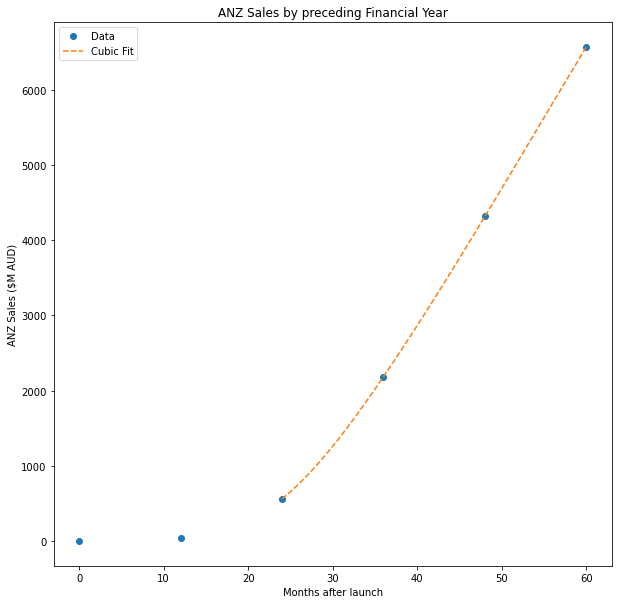

In [7]:
import numpy as np
import scipy

x = df.month_count.values
y = df.anz_underlying_sales_value
f2 = scipy.interpolate.interp1d(x, y, kind='cubic')

z = np.polyfit(x, y, 3)
print(z)

xnew = np.linspace(24, 60, num=61, endpoint=True)

plt.plot(x, y, 'o', xnew, f2(xnew), '--')
plt.legend(['Data','Cubic Fit'], loc='best')
plt.title('ANZ Sales by preceding Financial Year')
plt.xlabel('Months after launch')
plt.ylabel('ANZ Sales ($M AUD)')
plt.show()




In [8]:
with pm.Model() as model:
    millions_customers = df.anz_underlying_sales_value.values
    x = df.month_count.values.astype(np.float64)
    L =  pm.Uniform('L', lower = 0, upper = 200_000) 
    k =  pm.Uniform('k', lower=0, upper=1) 
    x0 = pm.Uniform('x0', lower=0, upper=100) 
    
    customers_predicted = L/(1+math.e**(-k*(x-x0)))
    customers = pm.Normal('customers', mu = customers_predicted, sigma = 100, observed = millions_customers)
    

In [9]:
with model:
    trace = pm.sample(draws=10_000,tune=5_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x0, k, L]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [00:20<00:00, 1470.55draws/s]
The acceptance probability does not match the target. It is 0.6988053991948783, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


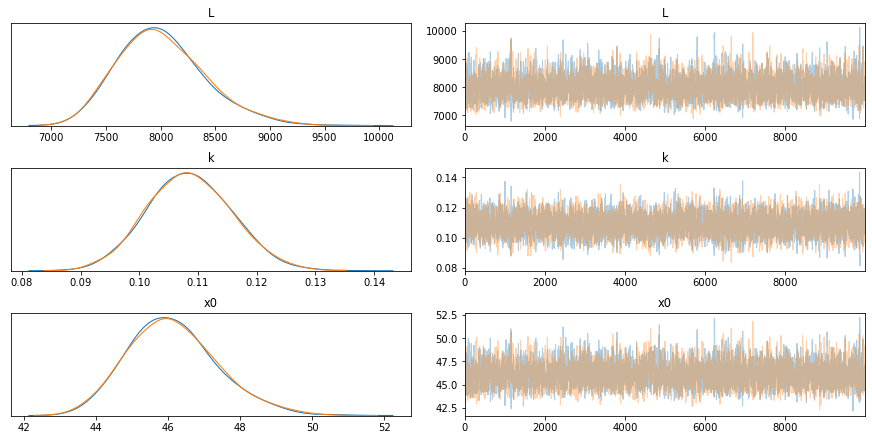

In [10]:
pm.traceplot(trace);

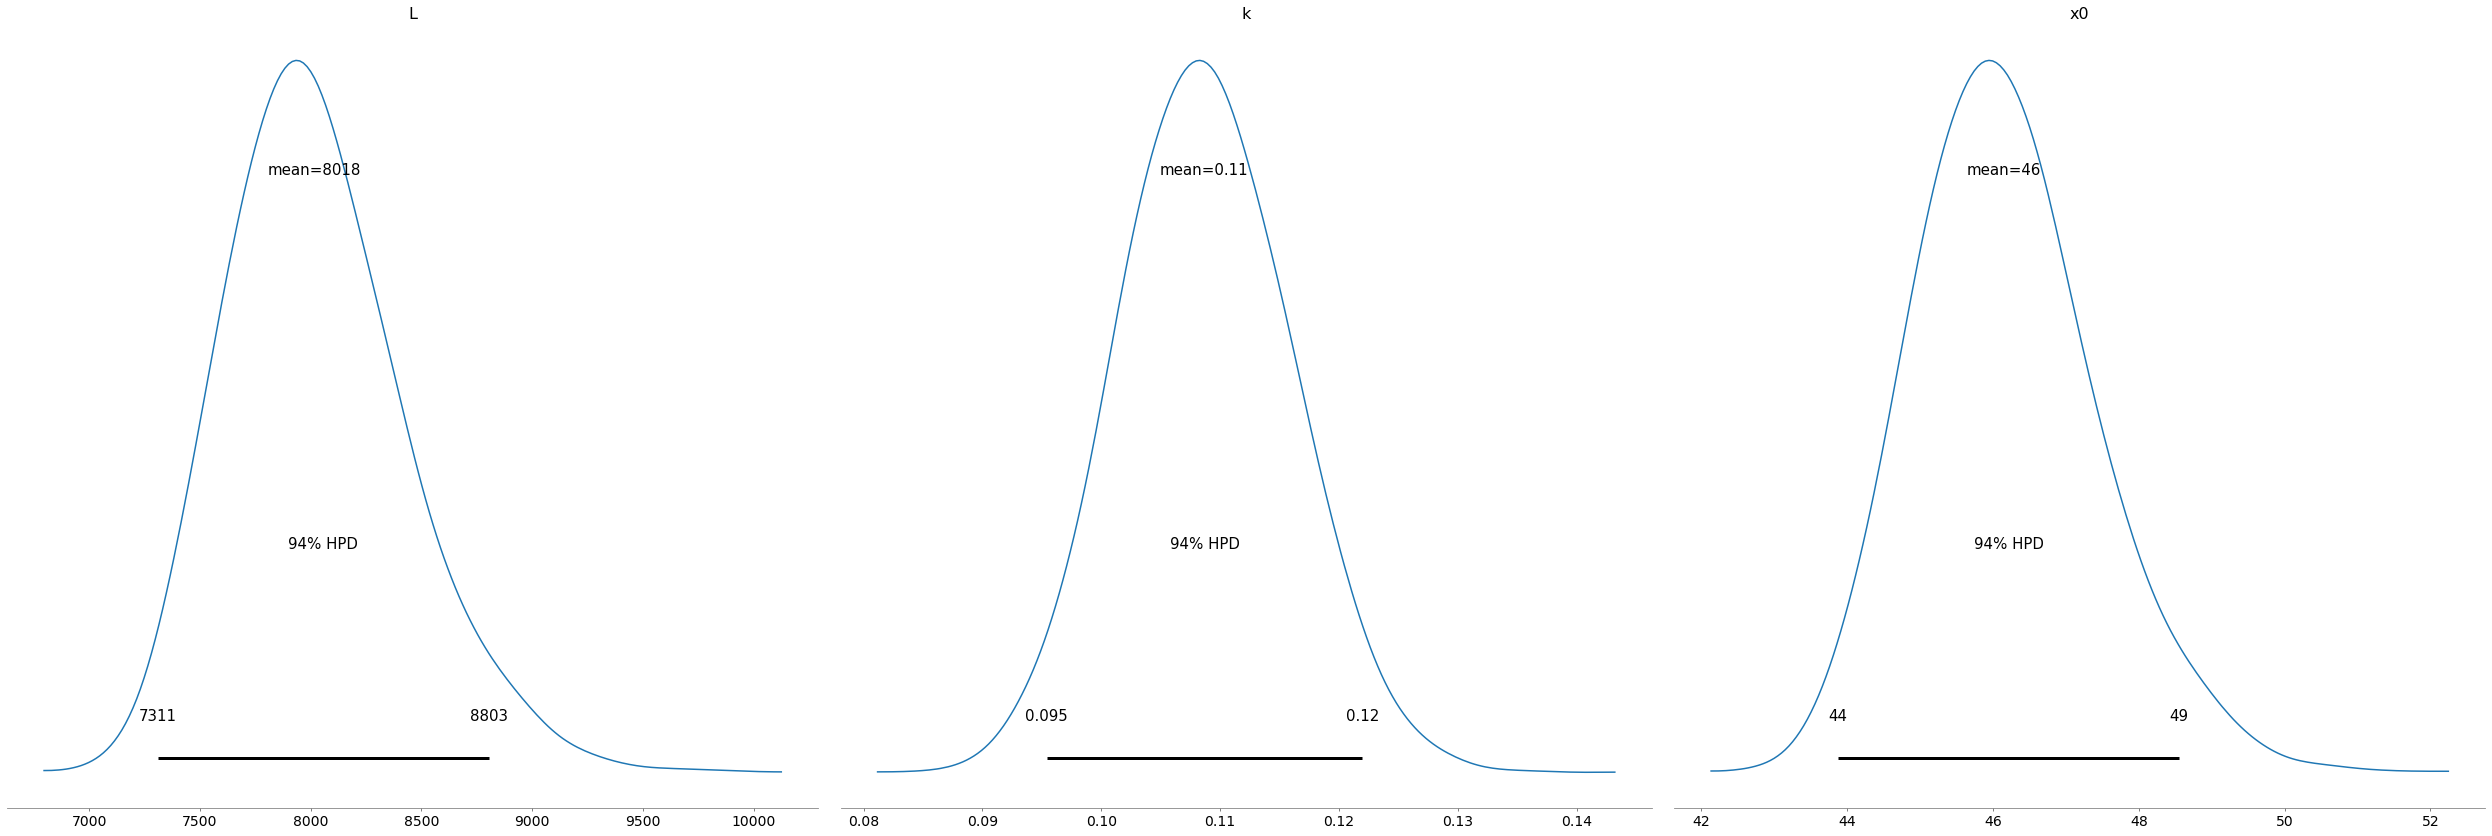

In [11]:
pm.plot_posterior(trace);

In [12]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
L,8017.789,405.424,7310.574,8803.450,6.689,4.757,3674.0,3632.0,3829.0,3979.0,1.0
k,0.109,0.007,0.095,0.122,0.000,0.000,4266.0,4266.0,4233.0,4638.0,1.0
x0,46.148,1.254,43.871,48.554,0.020,0.015,3759.0,3734.0,3897.0,3852.0,1.0


## Posterior Predictive Checks
Let's see if our model makes sense. By drawing samples from our model, we can further investigate the potential growth rates of Afterpay. 

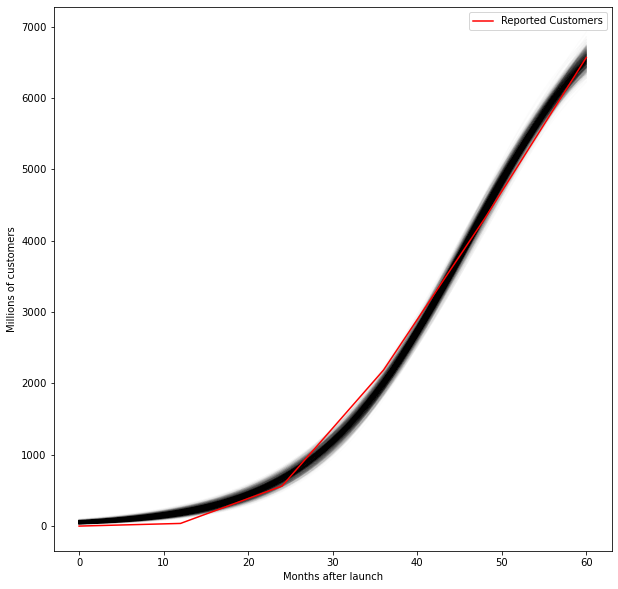

In [13]:
for i in range(0,1_000):
    x = np.arange(0,61)
    plt.plot(x,trace['L'][i]/(1+math.e**(-trace['k'][i]*(x-trace['x0'][i]))),color='k',alpha=0.01)
plt.plot(df.month_count,df.anz_underlying_sales_value,color='r',label='Reported Customers')

plt.legend()
plt.ylabel('Millions of customers')
plt.xlabel('Months after launch')
plt.show()

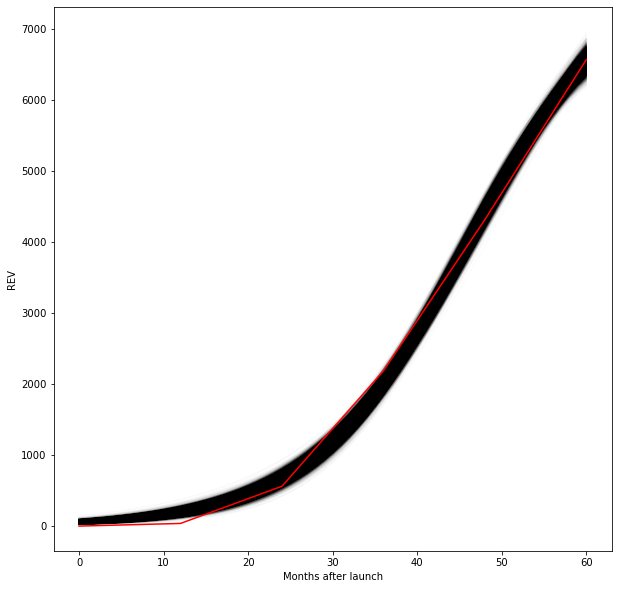

In [14]:

for i in range(0,10_000):
    x = np.arange(0,61)
    rev = trace['L'][i]/(1+math.e**(-trace['k'][i]*(x-trace['x0'][i])))
    losses = 0.008 * trace['L'][i]/(1+math.e**(-trace['k'][i]*(x-trace['x0'][i])))
    
    plt.plot(x,rev,color='k',alpha=0.01)
    
    
plt.plot(df.month_count,df.anz_underlying_sales_value,color='r',label='Reported Customers')
   

plt.ylabel('REV')
plt.xlabel('Months after launch')
plt.show()

0 0.8 9.078746534844535e-17
1 0.8768924792462777 0.0053325080670845815
2 0.9596556382575269 0.011491015297085
3 1.0484388151895756 0.018512270974545605
4 1.1433363710266302 0.026419431764464006
5 1.2443776390617562 0.03521892179569219
6 1.351517319435952 0.04489751495489178
7 1.4646268658138089 0.05541989380646474
8 1.5834874649479926 0.06672696101080594
9 1.7077852243254332 0.07873517444965368
10 1.8371091466871534 0.09133713942373317
11 1.9709523752419522 0.10440361685716969
12 2.1087170383921188 0.11778699755165799


In [16]:
for shift in range(0,13):
    loss_rates = []
    for i in range(0,10_000):
        x = np.arange(0,31)
        rev = df.anz_underlying_sales_value.values
        losses = 0.008 * df.anz_underlying_sales_value.values

        loss_rate = 100*losses/rev
        loss_rates.append(loss_rate[-1])

    loss_rates = np.array(loss_rates)

    print(shift,np.mean(loss_rates),np.std(loss_rates))

#plt.hist(loss_rates)
#plt.show()

0 0.8000000000000002 2.220446049250313e-16
1 0.8000000000000002 2.220446049250313e-16
2 0.8000000000000002 2.220446049250313e-16
3 0.8000000000000002 2.220446049250313e-16
4 0.8000000000000002 2.220446049250313e-16
5 0.8000000000000002 2.220446049250313e-16
6 0.8000000000000002 2.220446049250313e-16
7 0.8000000000000002 2.220446049250313e-16
8 0.8000000000000002 2.220446049250313e-16
9 0.8000000000000002 2.220446049250313e-16
10 0.8000000000000002 2.220446049250313e-16
11 0.8000000000000002 2.220446049250313e-16
12 0.8000000000000002 2.220446049250313e-16
